# SUPPORT VECTOR REGRESSOR

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm

## IMPORTAR DATOS

In [18]:
# Cargar los datos
data = pd.read_csv('data_input.csv')
data['fecha'] = pd.to_datetime(data['fecha'])
data.set_index('fecha', inplace=True)

## PREPROCESAR DATOS

In [79]:
# Crear características de entrada (lags)
def create_lags(data, n_lags=5):
    df = pd.DataFrame(data)
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['pm10'].shift(i)
    df = df.dropna()
    return df

n_lags = 25
df_lags = create_lags(data['pm10'], n_lags)

# Proporciones de división
train_proportion = 0.80
val_proportion = 0.1990
test_proportion = 0.0010 # lo suficientemente pequeno para visualizar 

# Calcular los índices para las divisiones
n = len(df_lags)
train_end = int(train_proportion * n)
val_end = train_end + int(val_proportion * n)

# Dividir los datos en entrenamiento, validación y prueba
train = df_lags.iloc[:train_end]
val = df_lags.iloc[train_end:val_end]
test = df_lags.iloc[val_end:]

X_train, y_train = train.drop('pm10', axis=1), train['pm10']
X_val, y_val = val.drop('pm10', axis=1), val['pm10']
X_test, y_test = test.drop('pm10', axis=1), test['pm10']

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Opcionalmente, imprimir los tamaños de cada división
print(f'Tamaño de entrenamiento: {len(train)}')
print(f'Tamaño de validación: {len(val)}')
print(f'Tamaño de prueba: {len(test)}')

Tamaño de entrenamiento: 40856
Tamaño de validación: 10163
Tamaño de prueba: 52


<Figure size 1200x600 with 0 Axes>

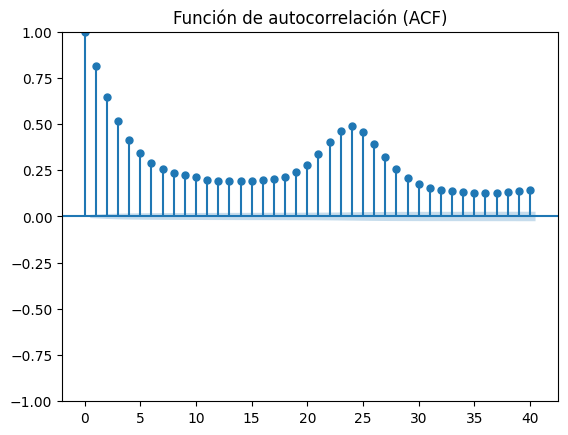

In [80]:
from statsmodels.graphics.tsaplots import plot_acf

# Graficar la función de autocorrelación y autocorrelación parcial
plt.figure(figsize=(12, 6))
plot_acf(data['pm10'].dropna(), lags=40, alpha=0.05)
plt.title('Función de autocorrelación (ACF)')
plt.show()

se decide entonces utilizar 25 lags para entrenar el modelo

## ENTRENAR MODELO

In [5]:
# Entrenar el modelo SVR
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr.fit(X_train_scaled, y_train)

SVR(C=1000.0, gamma=0.1)

debido al alto tiempo de entrenamiento para un modelo (180 minutos) se decide no hacer busqueda de hiperparametros por temas de recursos computacionales.

## EVALUAR MODELO

se evalua el modelo y se calculan metricas de regresión con un tamaño de test equivalente a dos días de información

In [81]:
# Hacer predicciones
y_pred_train = svr.predict(X_train_scaled)
y_pred_val = svr.predict(X_val_scaled)

### autocorrelacion de los residuales

<Figure size 1200x600 with 0 Axes>

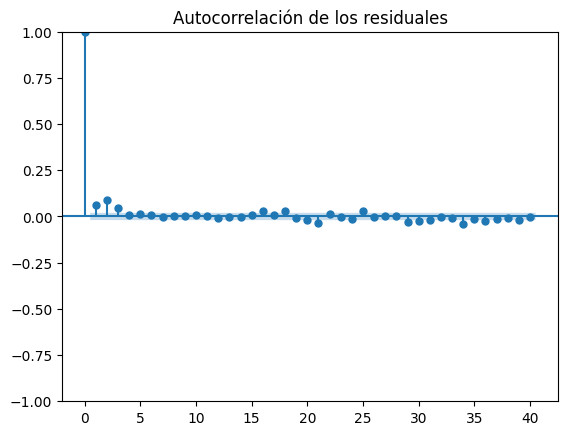

In [85]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# Calcular los residuos
residuals_train = y_train - y_pred_train
residuals_val = y_val - y_pred_val

# Graficar la autocorrelación de los residuos
plt.figure(figsize=(12, 6))
plot_acf(residuals_val, lags=40, alpha=0.05)
plt.title('Autocorrelación de los residuales')
plt.show()

como se puede apreciar. La autocorrelación es especialmente mayor en los primeros lags, luego en los siguientes no es tan así. Incluso de denota que esta es mucho menor que la autocorrelación de los lags en el conjunto de entrenamiento.

### metricas de regresion

Test MAE: 13.435
Test MSE: 263.604
Test RMSE: 16.236
Test MAPE: 63.402%
Test R2: 0.313


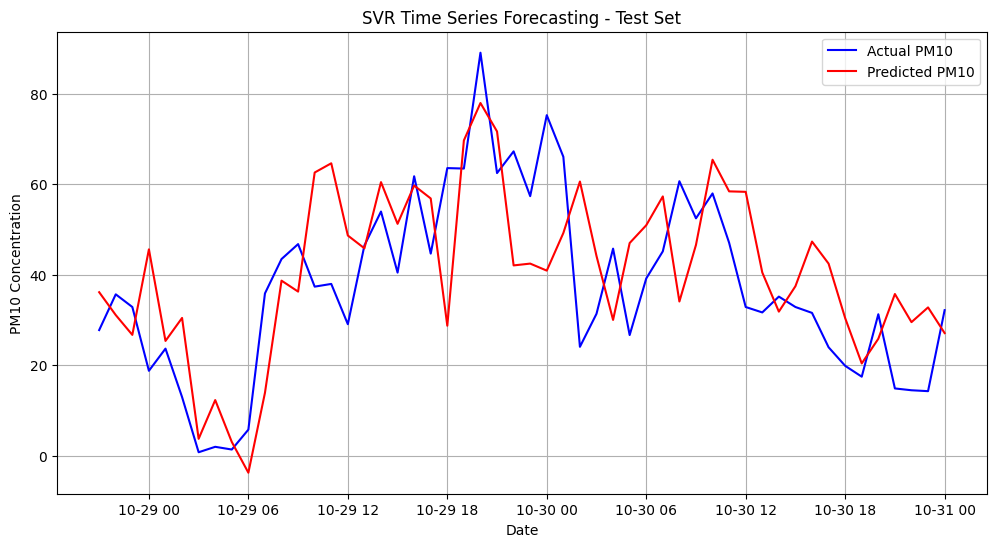

In [75]:
# Hacer predicciones en el conjunto de prueba
y_pred_test = svr.predict(X_test_scaled)

# # Paso 5: Evaluar el modelo en el conjunto de prueba y visualizar las predicciones
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
test_r2 = r2_score(y_test, y_pred_test)

print(f'Test MAE: {test_mae:.3f}')
print(f'Test MSE: {test_mse:.3f}')
print(f'Test RMSE: {test_rmse:.3f}')
print(f'Test MAPE: {test_mape:.3f}%')
print(f"Test R2: {test_r2:.3f}")

# Visualizar las predicciones futuras en el conjunto de prueba
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual PM10', color='blue')
plt.plot(test.index, y_pred_test, label='Predicted PM10', color='red')
plt.title('SVR Time Series Forecasting - Test Set')
plt.xlabel('Date')
plt.ylabel('PM10 Concentration')
plt.legend()
plt.grid(True)
plt.show()